In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Environment definition
We create here the corridor environment. The number of cells/states in the corridor is set by default to 3 but it can be changed when the class is instantiated.

In [142]:
class CorridorEnv:
    def __init__(self, n_states=3, is_slippery = False):
        self.nS = n_states
        self.nA = 3
        self.is_slippery = is_slippery
        self.s = 0
        self.prob = 0.9
        self.terminal_s = self.nS-1        
        self.model = {}
        for s in range(self.nS):
            self.model[s] = {}
            for a in range(self.nA):
                self.s = s
                s_, dropped = self.step(a)
                p1 = self.prob
                p2 = 1 - self.prob
                r = -10 if dropped else -1 
                d = bool(s == self.terminal_s)
                self.model[s][a] = [(p1, s_, r, d), (p2, np.int64(s), r, d)] if self.is_slippery else [(1.0, s_, r, d)]
        
        
    def reset(self):
        self.s = 0
        
    def step(self, a):
        if a == 0: # LEFT
            shift = -1
        elif a == 1: # DON'T MOVE
            shift = 0
        elif a == 2:
            shift = +1 # RIGHT
        else:
            raise

        if self.is_slippery:
            self.s = np.random.choice([self.s+shift, self.s], p=[self.prob, 1 - self.prob])
        else:
            self.s += shift
            
        dropped = (self.s<0 or self.s>=self.nS)
        return np.clip(self.s, 0, self.nS-1), dropped

We can now instantiate the environment object and some parameters such as the discount factor gamma and the policy

# Deterministic case
We define here both the environment and the policy to be deterministic. We do this by:
- setting the is_slippery flat to False in the corridor environment
- setting the policy to only have one action with non-zero probability for each state.

In [143]:
env = CorridorEnv(n_states=5, is_slippery=False)


n_states = env.nS
n_actions = env.nA
P_model = env.model

gamma = 1.0 # we are in a episodic task so it is ok to use a discount factor of 1

In [144]:
# Deterministic policy
policy = [[0, 0, 1]]*n_states

In [145]:
def annotated_heatmap(data, title):
    ylabels = ["states"]
    xlabels_idx = range(len(data[0]))
    xlabels= ["s"+str(x) for x in xlabels_idx]

    fig, ax = plt.subplots()
    im = ax.imshow(data)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(range(len(xlabels)), labels=xlabels, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(ylabels)), rotation=90, labels=ylabels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(ylabels)):
        for j in range(len(xlabels)):
            text = ax.text(j, i, round(data[i][j], 2),
                           ha="center", va="center", color="w")

    ax.set_title(title)
    fig.tight_layout()
    plt.show()

## 1) Analytic policy evaluation 

In [146]:
# Build transition matrix and reward vector under fixed policy
def analytical_policy_evaluation(pi, model):
    P = np.zeros((n_states, n_states))
    R = np.zeros(n_states)

    for s in range(n_states):
        for a in range(n_actions):
            for prob, s_prime, reward, done in model[s][a]:
                P[s, s_prime] = pi[s][a]*prob*(not done)
                R[s] += pi[s][a]*reward*prob*(not done)

    I = np.eye(n_states)
    V = np.linalg.inv(I - gamma * P) @ R

    np.set_printoptions(precision=1, suppress=True)
    return V

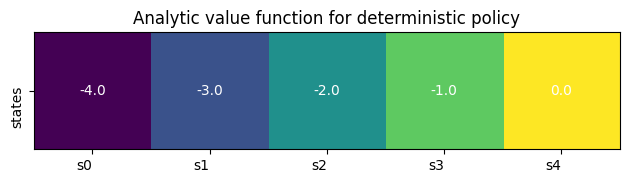

In [147]:
V = analytical_policy_evaluation(policy, P_model)
annotated_heatmap([V], "Analytic value function for deterministic policy")

## 2) Recursive policy evaluation

In [148]:
def bellman_update(V, pi, s, transitions):
    value = 0
    V = deepcopy(V)
    for a in range(n_actions):
        for p, s_, r, done in transitions[s][a]:
            value += pi[s][a]*p*(r + gamma*(V[s_]))*(not done)
    V[s] = value
    return value
    
def policy_evaluation(V, policy, transitions):
    count = 0
    # V_prev = V.copy()
    theta = 0.001
    delta = np.inf
    while delta > theta:
        # print("Iteration", count, V)
        count+=1
        delta = 0.0
        V_prev = deepcopy(V)
        for s in range(n_states):
            # print("V prev", V_prev)
            v = bellman_update(V_prev, policy, s, transitions)
            V[s] = v
            delta = max(delta, abs(v - V_prev[s]))
    return V

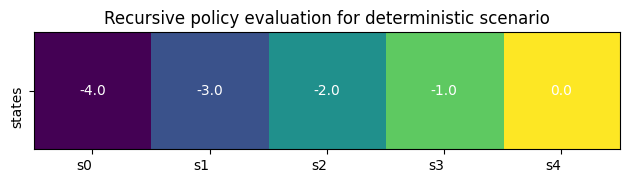

In [149]:
V = np.zeros(n_states)
policy_evaluation(V, policy, P_model)
annotated_heatmap([V], "Recursive policy evaluation for deterministic scenario")

# Stochastic policy and deterministic environment

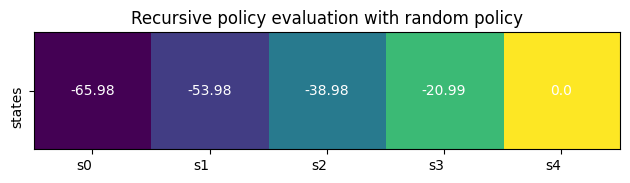

In [150]:
env = CorridorEnv(n_states=5, is_slippery=False)
policy = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution

V = np.zeros(n_states)
policy_evaluation(V, policy, env.model)
annotated_heatmap([V], "Recursive policy evaluation with random policy")

# Deterministic policy and stochastic corridor

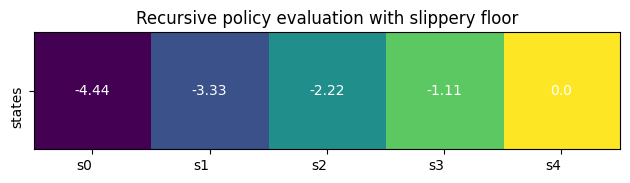

In [151]:
env = CorridorEnv(n_states=5, is_slippery=True)
policy = [[0, 0, 1]]*n_states # Set the policy to always move to the right towards the goal

V = np.zeros(n_states)
policy_evaluation(V, policy, env.model)
annotated_heatmap([V], "Recursive policy evaluation with slippery floor")

# Fully stochastic model

In [152]:
env = CorridorEnv(n_states=5, is_slippery=True)
policy = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution

V = np.zeros(n_states)
policy_evaluation(V, policy, nv.model)
annotated_heatmap([V], "Recursive policy evaluation with slippery floor")

NameError: name 'nv' is not defined